In [1]:
# Celda 1: Importaciones y Configuración del Benchmark para Pthreads

import subprocess
import time
import pandas as pd
import matplotlib.pyplot as plt
import os
import platform
from tqdm import tqdm
import numpy as np

# --- CONFIGURACIÓN DE LA PRUEBA PTHREADS ---

# 1. Carpeta para guardar todos los resultados
EXPERIMENT_DIR = "experimentos"

# 2. Parámetros de la malla y los hilos
GRID_LENGTH = "100"
NTHREADS_LIST = [1, 2, 4, 8, 16]

# 3. Implementaciones de Pthreads a probar (según tu Makefile)
PTHREADS_BINARIES = [
    "yee_block_pthr",
    "yee_stride1_pthr"
]

# 4. Número de repeticiones para promediar resultados
REPETICIONES = 3

# 5. Detección automática de la carpeta de binarios
ARCHNAME = f"{platform.system()}_{platform.machine()}"
BIN_DIR = f"{ARCHNAME}/bin"

# 6. Nombres de los archivos de salida para Pthreads
OUTPUT_CSV_PTHREADS = os.path.join(EXPERIMENT_DIR, f"resultados_pthreads_grid{GRID_LENGTH}.csv")
OUTPUT_PNG_TIME_PTHREADS = os.path.join(EXPERIMENT_DIR, f"rendimiento_pthreads_grid{GRID_LENGTH}.png")
OUTPUT_PNG_SPEEDUP_PTHREADS = os.path.join(EXPERIMENT_DIR, f"speedup_pthreads_grid{GRID_LENGTH}.png")

# --- PREPARACIÓN DEL ENTORNO ---
os.makedirs(EXPERIMENT_DIR, exist_ok=True)

print("--- Configuración para Pthreads Cargada ---")
print(f"Directorio de resultados: {EXPERIMENT_DIR}")
print(f"Directorio de binarios:   {BIN_DIR}")
print(f"Ejecutables a probar:     {PTHREADS_BINARIES}")
print(f"Hilos por prueba:         {NTHREADS_LIST}")
print(f"Tamaño de malla:          {GRID_LENGTH}")
print("---------------------------------------")
print("¡Listo para compilar en la siguiente celda!")

--- Configuración para Pthreads Cargada ---
Directorio de resultados: experimentos
Directorio de binarios:   Linux_x86_64/bin
Ejecutables a probar:     ['yee_block_pthr', 'yee_stride1_pthr']
Hilos por prueba:         [1, 2, 4, 8, 16]
Tamaño de malla:          100
---------------------------------------
¡Listo para compilar en la siguiente celda!


In [2]:
# Celda 2: Compilar los Ejecutables (Versión Universal)

print(f"=== Compilando todos los ejecutables en '{BIN_DIR}'... ===")
# La variable BIN_DIR fue definida en la Celda 1

try:
    # 'make bin' compila todos los binarios definidos en el Makefile.
    result = subprocess.run(["make", "bin"], check=True, capture_output=True, text=True)
    print("¡Compilación completada exitosamente!")
    
except FileNotFoundError:
    print("ERROR: El comando 'make' no se encontró. ¿Está instalado y en el PATH de tu entorno WSL?")
except subprocess.CalledProcessError as e:
    print("ERROR: 'make bin' falló. Revisa tu Makefile o el código fuente.")
    print("--- Salida de Error de 'make' ---")
    print(e.stderr)
    print("---------------------------------")# Celda 3: Ejecutar el Benchmark Pthreads y Medir Tiempos

all_results_pthreads = []
fallos_totales = 0

total_runs = len(PTHREADS_BINARIES) * len(NTHREADS_LIST) * REPETICIONES
progress_bar = tqdm(total=total_runs, desc="Ejecutando pruebas Pthreads", unit="run")

for binary_name in PTHREADS_BINARIES:
    executable_path = os.path.join(BIN_DIR, binary_name)
    if not os.path.exists(executable_path):
        print(f"SALTANDO: {binary_name} no se encontró en {executable_path}")
        progress_bar.update(len(NTHREADS_LIST) * REPETICIONES)
        continue
        
    for n_threads in NTHREADS_LIST:
        for i in range(REPETICIONES):
            # ¡IMPORTANTE! Aquí definimos el comando para Pthreads.
            # Asumimos que tu programa acepta el número de hilos con el flag '-t'.
            # Si tu programa usa otro flag (ej. --threads, -p), cámbialo aquí.
            command = [executable_path, "-n", GRID_LENGTH, "-t", str(n_threads)]
            
            start_time = time.time()
            try:
                subprocess.run(command, check=True, capture_output=True, text=True)
            except subprocess.CalledProcessError as e:
                print(f"\n¡FALLO! El comando '{' '.join(command)}' devolvió un error.")
                print("Stderr:", e.stderr)
                elapsed = None
                fallos_totales += 1
            else:
                end_time = time.time()
                elapsed = end_time - start_time

            all_results_pthreads.append({
                "binary": binary_name,
                "threads": n_threads,
                "run": i + 1,
                "time_s": elapsed
            })
            progress_bar.update(1)
            progress_bar.set_postfix_str(f"{binary_name} @ {n_threads}T")

progress_bar.close()
print(f"\n¡Benchmark Pthreads completado con {fallos_totales} fallos!")

df_raw_pthreads = pd.DataFrame(all_results_pthreads)
df_raw_pthreads = df_raw_pthreads.dropna(subset=['time_s'])

if df_raw_pthreads.empty:
    print("\n¡ERROR FATAL! No se pudo recolectar ningún dato de tiempo válido.")
else:
    print("\nMuestra de los tiempos medidos:")
    display(df_raw_pthreads.head())

=== Compilando todos los ejecutables en 'Linux_x86_64/bin'... ===
¡Compilación completada exitosamente!


Ejecutando pruebas Pthreads:  60%|▌| 18/30 [00:00<00:00, 98.78run/s, yee_stride1


¡FALLO! El comando 'Linux_x86_64/bin/yee_block_pthr -n 100 -t 16' devolvió un error.
Stderr: double free or corruption (!prev)


¡FALLO! El comando 'Linux_x86_64/bin/yee_block_pthr -n 100 -t 16' devolvió un error.
Stderr: double free or corruption (!prev)


¡FALLO! El comando 'Linux_x86_64/bin/yee_block_pthr -n 100 -t 16' devolvió un error.
Stderr: free(): invalid next size (normal)



Ejecutando pruebas Pthreads: 100%|█| 30/30 [00:00<00:00, 48.64run/s, yee_stride1



¡Benchmark Pthreads completado con 3 fallos!

Muestra de los tiempos medidos:


,binary,threads,run,time_s
0,yee_block_pthr,1,1,0.009363
1,yee_block_pthr,1,2,0.009097
2,yee_block_pthr,1,3,0.008924
3,yee_block_pthr,2,1,0.010723
4,yee_block_pthr,2,2,0.009806


Resultados Pthreads crudos guardados en 'experimentos/resultados_pthreads_grid100.csv'

Tiempos de ejecución Pthreads promediados:


,binary,threads,time_s
0,yee_block_pthr,1,0.009128
1,yee_block_pthr,2,0.010178
2,yee_block_pthr,4,0.009780
3,yee_block_pthr,8,0.009873
4,yee_stride1_pthr,1,0.009640
5,yee_stride1_pthr,2,0.012667
6,yee_stride1_pthr,4,0.014410
7,yee_stride1_pthr,8,0.012681
8,yee_stride1_pthr,16,0.012791



Generando gráfica de rendimiento Pthreads y guardando en 'experimentos/rendimiento_pthreads_grid100.png'...


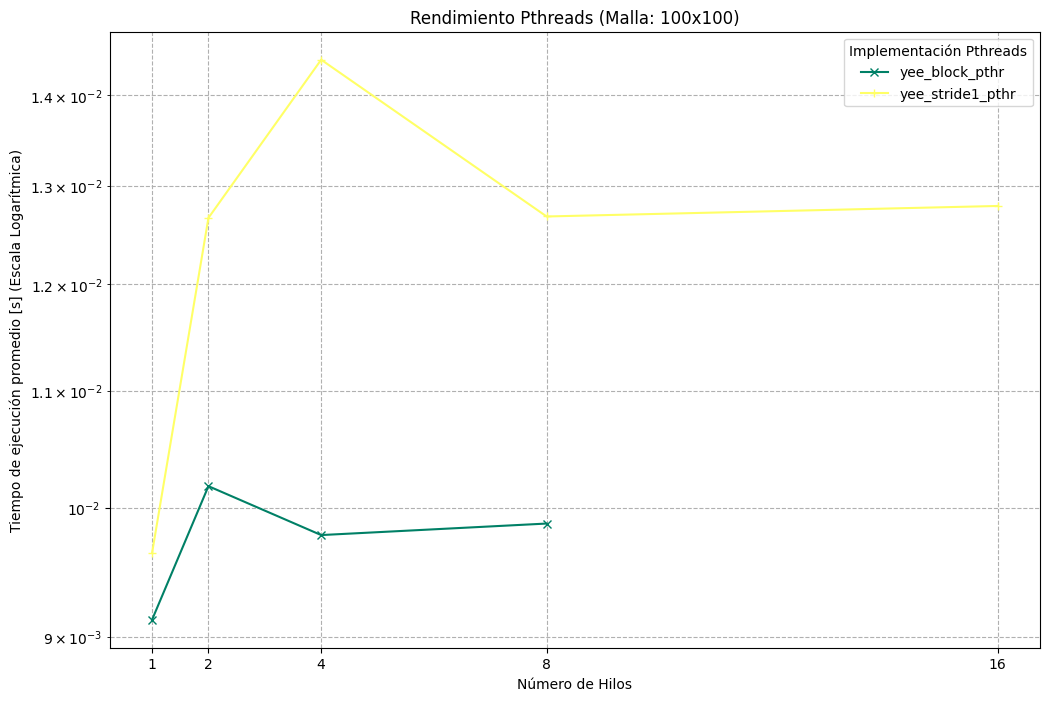

In [3]:
# Celda 4: Procesar Datos Pthreads y Generar Gráfica de Tiempo vs. Hilos

if 'df_raw_pthreads' in locals() and not df_raw_pthreads.empty:
    df_raw_pthreads.to_csv(OUTPUT_CSV_PTHREADS, index=False)
    print(f"Resultados Pthreads crudos guardados en '{OUTPUT_CSV_PTHREADS}'")

    df_mean_pthreads = df_raw_pthreads.groupby(["binary", "threads"])["time_s"].mean().reset_index()

    print("\nTiempos de ejecución Pthreads promediados:")
    display(df_mean_pthreads)

    print(f"\nGenerando gráfica de rendimiento Pthreads y guardando en '{OUTPUT_PNG_TIME_PTHREADS}'...")
    fig, ax = plt.subplots(figsize=(12, 8))
    
    colors = plt.cm.summer(np.linspace(0, 1, len(PTHREADS_BINARIES)))
    markers = ['x', '+']
    for i, binary_name in enumerate(PTHREADS_BINARIES):
        subset = df_mean_pthreads[df_mean_pthreads["binary"] == binary_name]
        ax.plot(subset["threads"], subset["time_s"], marker=markers[i], linestyle='-', color=colors[i], label=binary_name)

    ax.set_xlabel("Número de Hilos")
    ax.set_ylabel("Tiempo de ejecución promedio [s] (Escala Logarítmica)")
    ax.set_title(f"Rendimiento Pthreads (Malla: {GRID_LENGTH}x{GRID_LENGTH})")
    ax.set_xticks(NTHREADS_LIST)
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='--')
    ax.legend(title="Implementación Pthreads")
    plt.savefig(OUTPUT_PNG_TIME_PTHREADS, dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No se generaron resultados de Pthreads válidos.")

Tabla de Speedup Pthreads:


,binary,threads,time_s,speedup
0,yee_block_pthr,1,0.009237,1.000000
1,yee_block_pthr,2,0.011017,0.838398
2,yee_block_pthr,4,0.010502,0.879516
3,yee_block_pthr,8,0.010416,0.886797
4,yee_stride1_pthr,1,0.010292,1.000000
5,yee_stride1_pthr,2,0.009508,1.082424
6,yee_stride1_pthr,4,0.014546,0.707531
7,yee_stride1_pthr,8,0.013560,0.758945
8,yee_stride1_pthr,16,0.013527,0.760804



Generando gráfica de speedup Pthreads y guardando en 'experimentos/speedup_pthreads_grid100.png'...


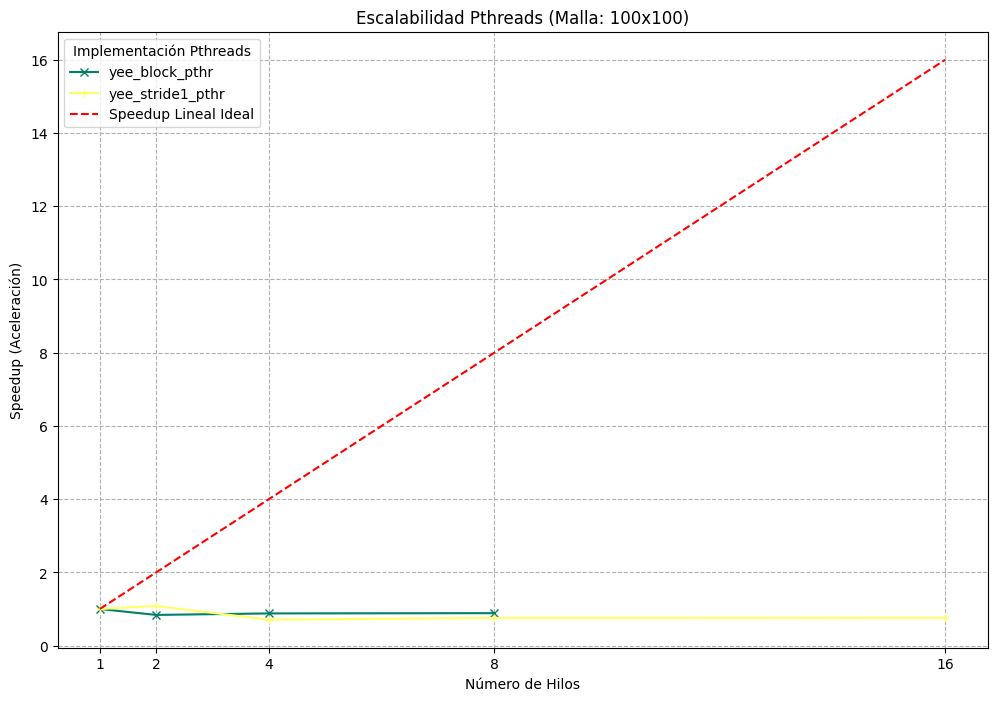

In [4]:
# Celda 5: Calcular y Graficar el Speedup de Pthreads

if 'df_mean_pthreads' in locals() and not df_mean_pthreads.empty:
    df_speedup_pthreads = pd.DataFrame()
    for binary_name in PTHREADS_BINARIES:
        subset = df_mean_pthreads[df_mean_pthreads["binary"] == binary_name].copy()
        time_1_thread = subset[subset["threads"] == 1]["time_s"].iloc[0]
        subset["speedup"] = time_1_thread / subset["time_s"]
        df_speedup_pthreads = pd.concat([df_speedup_pthreads, subset])
        
    print("Tabla de Speedup Pthreads:")
    display(df_speedup_pthreads)

    print(f"\nGenerando gráfica de speedup Pthreads y guardando en '{OUTPUT_PNG_SPEEDUP_PTHREADS}'...")
    fig, ax = plt.subplots(figsize=(12, 8))
    
    colors = plt.cm.summer(np.linspace(0, 1, len(PTHREADS_BINARIES)))
    markers = ['x', '+']
    for i, binary_name in enumerate(PTHREADS_BINARIES):
        subset = df_speedup_pthreads[df_speedup_pthreads["binary"] == binary_name]
        ax.plot(subset["threads"], subset["speedup"], marker=markers[i], linestyle='-', color=colors[i], label=binary_name)
    
    ax.plot(NTHREADS_LIST, NTHREADS_LIST, linestyle='--', color='red', label='Speedup Lineal Ideal')
    ax.set_xlabel("Número de Hilos")
    ax.set_ylabel("Speedup (Aceleración)")
    ax.set_title(f"Escalabilidad Pthreads (Malla: {GRID_LENGTH}x{GRID_LENGTH})")
    ax.set_xticks(NTHREADS_LIST)
    ax.grid(True, which="both", linestyle='--')
    ax.legend(title="Implementación Pthreads")
    plt.savefig(OUTPUT_PNG_SPEEDUP_PTHREADS, dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No se generaron resultados Pthreads válidos para calcular el speedup.")

In [5]:
# Celda 6 (Pthreads): Benchmark de Tamaño de Malla con 8 Hilos

print("\n--- INICIANDO BENCHMARK DE TAMAÑO DE MALLA (Pthreads) ---")

# --- Configuración para esta prueba ---
NTHREADS_FIXED_PTHR = 8
GRID_LENGTH_LIST_PTHR = np.arange(500, 1010, 50)
REPETICIONES_GRID_PTHR = 1
OUTPUT_CSV_GRIDSIZE_PTHR = os.path.join(EXPERIMENT_DIR, f"resultados_gridsize_pthreads_n{NTHREADS_FIXED_PTHR}.csv")

results_grid_pthreads = []
total_runs = len(PTHREADS_BINARIES) * len(GRID_LENGTH_LIST_PTHR) * REPETICIONES_GRID_PTHR
progress_bar = tqdm(total=total_runs, desc=f"Pthreads @ {NTHREADS_FIXED_PTHR} hilos", unit="run")

# Bucle principal sobre el tamaño de la malla
for grid_length in GRID_LENGTH_LIST_PTHR:
    grid_length_str = str(grid_length)
    for binary_name in PTHREADS_BINARIES:
        for i in range(REPETICIONES_GRID_PTHR):
            executable_path = os.path.join(BIN_DIR, binary_name)
            command = [executable_path, "-n", grid_length_str, "-t", str(NTHREADS_FIXED_PTHR)]
            
            start_time = time.time()
            try:
                subprocess.run(command, check=True, capture_output=True, text=True)
                elapsed = time.time() - start_time
                results_grid_pthreads.append({"binary": binary_name, "grid_size": grid_length, "time_s": elapsed})
            except Exception as e:
                print(f"Fallo en {binary_name} con malla {grid_length}: {e}")
            progress_bar.update(1)
            
progress_bar.close()

# Guardar resultados
if results_grid_pthreads:
    df_grid_pthreads = pd.DataFrame(results_grid_pthreads)
    df_grid_pthreads.to_csv(OUTPUT_CSV_GRIDSIZE_PTHR, index=False)
    print(f"\nResultados de tamaño de malla para Pthreads guardados en '{OUTPUT_CSV_GRIDSIZE_PTHR}'")
    display(df_grid_pthreads.head())
else:
    print("\nNo se recolectaron datos para el benchmark de tamaño de malla de Pthreads.")


--- INICIANDO BENCHMARK DE TAMAÑO DE MALLA (Pthreads) ---


Pthreads @ 8 hilos:   5%|██▊                                                            | 1/22 [00:06<02:13,  6.37s/run]
KeyboardInterrupt

